In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
from torch import nn
from torch import distributions
from torch.distributions import (
    Normal,
    MultivariateNormal,
    Uniform,
    TransformedDistribution,
    SigmoidTransform,
)
from torch.nn.parameter import Parameter

from nflib.flows import (
    AffineConstantFlow,
    ActNorm,
    Invertible1x1Conv,
    NormalizingFlow,
    NormalizingFlowModel,
)
from nflib.spline_flows import NSF_CL

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
elif device.type == "cpu":
    print('Using the cpu...')

Using the cpu...


In [4]:
# choose data here
spectra = np.loadtxt("./data/jo_batch_spectra.csv")

In [5]:
spectra = spectra[:, 1:]
spectra = spectra.T
spectra = torch.Tensor(spectra)
dim = spectra.shape[-1]
print(dim)

5000


In [6]:
# choose prior here
base_mu, base_cov = torch.zeros(dim).to(device), torch.eye(dim).to(device)
prior = MultivariateNormal(base_mu, base_cov)

In [7]:
# configure the normalising flow
nfs_flow = NSF_CL
flows = [nfs_flow(dim=dim, K=8, B=3, hidden_dim=128) for _ in range(5)]
convs = [Invertible1x1Conv(dim=dim) for _ in flows]
norms = [ActNorm(dim=dim) for _ in flows]
flows = list(itertools.chain(*zip(norms, convs, flows)))

> the training 

In [ ]:
# initialise the model
# model = NormalizingFlowModel(prior, flows).to(device)
# optimizer
#optimizer = optim.Adam(model.parameters(), lr=2e-6, weight_decay=0)  # todo tune WD
#print("number of params: ", sum(p.numel() for p in model.parameters()))
# train_loader
#train_loader = torch.utils.data.DataLoader(
#    spectra, batch_size=71, shuffle=True, pin_memory=True
#)

#model.train()
#print("Started training")
#for k in range(20000):
#    for batch_idx, data_batch in enumerate(train_loader):
#        x = data_batch.to(device)
#        zs, prior_logprob, log_det = model(x)
#        logprob = prior_logprob + log_det
#        loss = -torch.sum(logprob)  # NLL

#        model.zero_grad()
#        loss.backward()
#        optimizer.step()

#    if k % 500 == 0:
#        print("Loss at step k =", str(k) + ":", loss.item())
        
#path = f"model_galah_batch.pth"
#torch.save(model.state_dict(), path)
#print("Hooray. You're done.")
#print("Saved model to:", path)

In [8]:
fname = f'model_galah_batch.pth'
state_dict = torch.load(fname, map_location=torch.device('cpu'))

model = NormalizingFlowModel(prior, flows).to(device)

model.eval()

NormalizingFlowModel(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): ActNorm()
      (1): Invertible1x1Conv()
      (2): NSF_CL(
        (f1): MLP(
          (net): Sequential(
            (0): Linear(in_features=2500, out_features=128, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=128, out_features=128, bias=True)
            (5): LeakyReLU(negative_slope=0.2)
            (6): Linear(in_features=128, out_features=57500, bias=True)
          )
        )
        (f2): MLP(
          (net): Sequential(
            (0): Linear(in_features=2500, out_features=128, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=128, out_features=128, bias=True)
        

In [9]:
zs = model.sample(50)
z = zs[-1]
z = z.to('cpu')
z = z.detach().numpy()

> how it should look like...

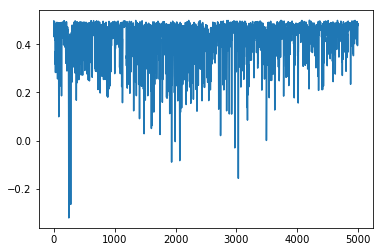

In [12]:
plt.plot(spectra[0]-0.5)

> how it looks like...

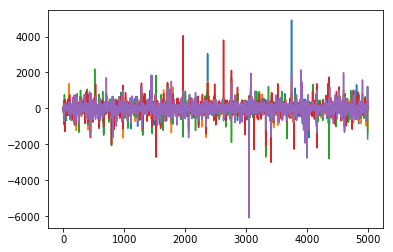

In [10]:
fig = plt.figure()

for i in range(5):
    plt.plot(z[i])